##############################################################

# **Land Cover** 

##############################################################

# 1. Introduction

When doing a spatial analysis, it is always usefull to derive data on the land cover/land use of your research area. For example, if we want to assess the impact of drought on grasslands, we do not want to look at phenology and NDVI values of forests and shrublands. In order to demarcate or mask the pixels that represent grassland we can make a landcover mask. In this notebook we will briefly look at how we can access and use land cover data. 

We will zoom in on one dataset: 
1. Worldcover: A high resolution LandCover dataset is the WorldCover Map from ESA with a resolution of 10m! Currntely only the 2020 datset is available. It can be accessed through the terrascope platform from VITO. More information: https://esa-worldcover.org/en


Outline of this notebook: 

- [1. Introduction](#1.-Introdution)
- [2. Libraries](#2.-Loading-libraries)
- [3. Terrascope WorldCover](#3.-Terrascope-WorldCover)

# 2. Loading libraries

In [166]:
import datetime as dt
import getpass
from terracatalogueclient import Catalogue
# initialize the catalogueclient
catalogue = Catalogue()
import ipywidgets as widgets
import rasterio
from rasterio.plot import show
import xarray
import rioxarray
import os
import sys
import glob
from osgeo import gdal
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import json
from shapely.geometry import box
import geopandas as gpd
import numpy.ma as ma
import requests

# 3. Terrascope WorldCover

In order to access this free data you need register first, as we will need you username and password in this notebook to directly download files into the innovation lab. To register you can visit the following website: https://terrascope.be/en

## 3.1 Explore the Terrascope platform

As you will se the Terrascope platforms offers a wide range of products primarily derived from the Sentinel Copernicus program. 

In [ ]:
# get all collections
collections = catalogue.get_collections()
for collection in collections:
    print("{}: {}".format(collection.id, collection.properties['title']))

A lot of different requests can be made to filter the data you need (e.g., timeperiod, extent (in bbox or shapefile), cloudcover). For more information on how to acces the data via notebooks and work with the data, I recommend you check the notebook service provided by Terrascope: https://terrascope.be/en/services. The following cell represents a hypothetical query for an NDVI product with a specific timeperiod, bbox, and cloudcover:

In [ ]:
products = catalogue.get_products("urn:eop:VITO:TERRASCOPE_S2_NDVI_V2",
                                  start=dt.date(2020, 5, 1), end=dt.date(2020, 6, 1),
                                  bbox="4.96,51.28,5.06,51.36",
                                  cloudCover=10) # a cloud cover of < 10%
for product in products:
    print("{}: {} % clouds".format(product.title, product.properties["productInformation"]["cloudCover"]))

Now Let's try to access LandCover products for 2020 for a ceratin bbox:

In [ ]:
products = catalogue.get_products("urn:eop:VITO:ESA_WorldCover_10m_2020_V1", 
                                bbox="4.23646,51.299545,4.27990,51.32847")
for product in products:
    print("{}: {}, downloadlink: {}".format(product.title, product.properties["productInformation"], product.data[0].href))

You can use the link generated by the previous cell to download the map onto your pc. To download the data directly into the InnovationLab follow the next steps:

Step 1: Insert your username and password from Terrascope, if you made a type and already entered, you can just rerun this cell to correct.

In [106]:
def on_submit_func(button):
    button.disabled=True
    
pwd_input_user = widgets.Text(value='',
                             placeholder='Enter username',
                             description='Username:',
                             disabled=False)
pwd_input_user.on_submit(on_submit_func)

pwd_input_pass = widgets.Password(value='',
                             placeholder='Enter password',
                             description='Password:',
                             disabled=False)
pwd_input_pass.on_submit(on_submit_func)

widgets.VBox([pwd_input_user, pwd_input_pass])

Step 2: Run the following cell to download the data in the desired folder, you may alter the bbox if you want to change te area of interest.

In [ ]:
outputfolder = './LandCover'
products = catalogue.get_products("urn:eop:VITO:ESA_WorldCover_10m_2020_V1", 
                                bbox="4.23646,51.299545,4.27990,51.32847",
                                title="ESA_WorldCover_10m_2020_v100_N51E003")

catalogue.authenticate_non_interactive(username=pwd_input_user.value), password=pwd_input_pass.value) 
for product in products:
    catalogue.download_file(product.data[0], outputfolder)

## 3.2 Read LandCover map

The pixel values correspond to a cetain land cover code:

- 10: Tree cover 
- 20: Shrubland 
- 30: Grassland 
- 40: Cropland
- 50: Built-up 
- 60: Bare/sparse vegetation 
- 70: Snow and ice 
- 80: Permanent water bodies 
- 90: Herbaceous wetland 
- 95: Mangroves 
- 100: Moss and lichen

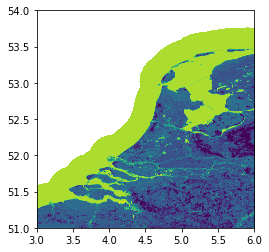

<AxesSubplot:>

In [7]:
# running this cell can take a while as it is a large tif-file
LC_img = rasterio.open(r'./LandCover/ESA_WorldCover_10m_2020_v100_N51E003_Map.tif')
show(LC_img)

In [22]:
LC = rioxarray.open_rasterio(r'./LandCover/ESA_WorldCover_10m_2020_v100_N51E003_Map.tif')
LC

<xarray.DataArray (band: 1, y: 36000, x: 36000)>
[1296000000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 3.0 3.0 3.0 3.0 3.0 3.0 ... 6.0 6.0 6.0 6.0 6.0 6.0
  * y            (y) float64 54.0 54.0 54.0 54.0 54.0 ... 51.0 51.0 51.0 51.0
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

## 3.3 Crop to extent

As you can see is this map rather detailed and takes a lot of storage. To improve computation efficiency we only focus on the area of interest, by cropping it to a shapefile:

In [65]:
input_fh=r"./LandCover/ESA_WorldCover_10m_2020_v100_N51E003_Map.tif" # path to the raster to be clipped
shp_fh=r"./LandCover/Test.shp" #path to the shapefile containing polygon of region of interest

output_folder=r'./LandCover'#path to output folder
if not os.path.exists(output_folder): #create output_folder if it does not exist
    os.makedirs(output_folder)
    
filename=os.path.basename(input_fh) #get filename from source_file path
output_fh=os.path.join(output_folder,filename[:-4] + '_crop.tif') #create a output file path
print(output_fh)

./LandCover/ESA_WorldCover_10m_2020_v100_N51E003_Map_crop.tif


In [66]:
gdal.Warp(output_fh, 
          gdal.Open(input_fh), 
          cutlineDSName = shp_fh, 
          cropToCutline = True, 
          dstNodata = 0).GetRasterBand(1)

<osgeo.gdal.Band; proxy of <Swig Object of type 'GDALRasterBandShadow *' at 0x7f234d0068d0> >

Check the new cropped map:

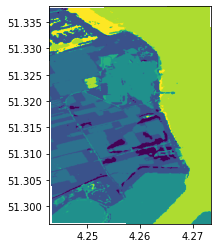

<AxesSubplot:>

In [108]:
LC_crop = rasterio.open(r'./LandCover/ESA_WorldCover_10m_2020_v100_N51E003_Map_crop.tif')
show(LC_crop)

In [75]:
LC_array = rasterio.open(r'./LandCover/ESA_WorldCover_10m_2020_v100_N51E003_Map_crop.tif').read()[0]
LC_array

array([[ 0,  0,  0, ..., 80, 80,  0],
       [ 0,  0,  0, ..., 80, 80,  0],
       [30, 30, 30, ..., 80, 80,  0],
       ...,
       [ 0,  0,  0, ..., 50, 50, 50],
       [ 0,  0,  0, ..., 50, 50, 50],
       [ 0,  0,  0, ..., 50, 50, 50]], dtype=uint8)

## 3.4 Make a mask

Now we are only interested in the pixels that contain cropland (40) or grassland (30), therefore we select only the values 30 & 40:

In [158]:
mask_bool = ma.masked_where((LC_array == 30) | (LC_array == 40), LC_array)
mask_crop_grass = mask_bool.mask*int(1)
mask_crop_grass = mask_crop_grass.astype('int32')

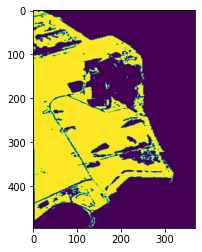

In [159]:
plt.imshow(mask_crop_grass)

We created an array with ones (LC of interest) and zeros (unrelevant LC's). We can write this layer as a tiff file to use it further on. When writing the tiff file, the zeros can be converted into nan values, so that further analysis will only be conducted on the LC of interest, increasing computational efficiency. 

In [ ]:
src = rasterio.open(r'./LandCover/ESA_WorldCover_10m_2020_v100_N51E003_Map_crop.tif')
array = mask_crop_grass
output_fh = r'./LandCover/LC_mask.tif'
raster = rasterio.open(
        output_fh,
        "w",
        driver=src.driver,
        width=src.width,
        height=src.height,
        count=1,  # number of bands 1 for mask
        crs=src.crs,
        transform=src.transform,
        dtype=array.dtype, 
        nodata=0 
    )
raster.write(array, 1)
raster.close()